In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import namedtuple, deque

# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

for _ in range(1000):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

### Here We Train our lunar lander but using Multiple Envirenment Running at the in parallel ###

episode_rewards:  [-184.63393524320304, -205.3142067187519, -275.0668961535554, -138.15569774684852, -43.088075653330556, -121.17113610401512, -167.38096730181414, -93.75606213451594, -118.69273845738589, -112.8313981877345, -176.66524436063753, -98.93433264483258, -259.61690459827827, -159.89465373581052, -96.3741293239367, -245.31902097211795, -102.9483408503458, -230.573039857965, -150.32241603474884, -94.88275371388441]
Episode 0, Episodes Completed: 20, Avg Reward: -153.78, Epsilon: 0.995, Memory: 2000
New best! Previous: -inf, Current: -153.78
episode_rewards:  [-63.399342438621304, -137.38743644281885, -339.5858680325493, -104.4987349996073, -82.2026942376693, -104.71985231185931, -77.96600486193219, -34.87341746907981, -315.2667608325423, 22.3784275624415, 24.255407990130095, -292.69957184685336, -148.17972376749577, -242.1211356118958, -279.481307712702, -121.0946558146913, -194.58112392369367, -94.3606621665419, -101.83508273644766, -99.64260112012572]
Episode 1, Episodes Com

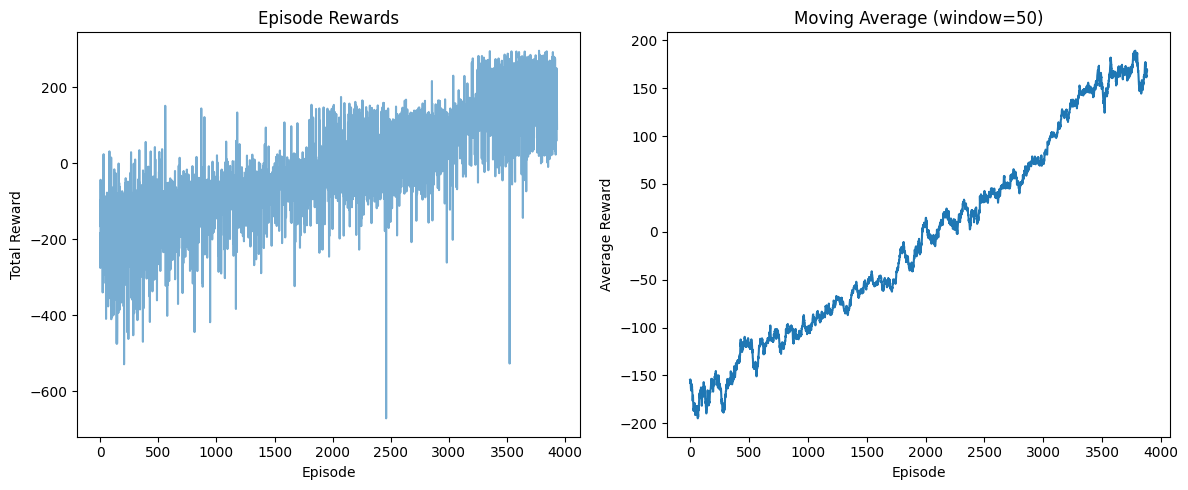


Training complete! Best average reward: 248.74
Total episodes completed: 3931


In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
from gymnasium.vector import SyncVectorEnv
from gymnasium.wrappers import TimeLimit

ENV_NAME = "LunarLander-v3"
LEARNING_RATE = 0.001
EPISODES = 500
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01  # Changed from 0.00 to 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 50000  # Increased for multiple envs
TARGET_UPDATE = 10
NUM_ENV = 4

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def select_action(policy_net, states, epsilon, num_envs, action_space):
    """Select actions for all environments"""
    if random.random() < epsilon:
        # Random actions for all environments
        return np.array([action_space.sample() for _ in range(num_envs)])
    else:
        with torch.no_grad():
            states_tensor = torch.tensor(states, dtype=torch.float32)
            return policy_net(states_tensor).argmax(dim=1).numpy()

def train_dqn(policy_net, target_net, memory, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    
    sample = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*sample))

    states = torch.tensor(np.array(batch.state), dtype=torch.float32)
    actions = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1)
    next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32)
    rewards = torch.tensor(batch.reward, dtype=torch.float32)
    dones = torch.tensor(batch.done, dtype=torch.float32)

    current_q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach()
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)  # Gradient clipping
    optimizer.step()

# Create vectorized environments
max_episode_steps=300
def make_env():
    env = gym.make(ENV_NAME)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)  # ← Add this!
    return env

envs = SyncVectorEnv([make_env for _ in range(NUM_ENV)])

state_dim = envs.single_observation_space.shape[0]
action_dim = envs.single_action_space.n

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
# policy_net.load_state_dict(torch.load("dqn_lunar_lander_mul_env.pth")) uncomment this line to continues training 
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)

epsilon = EPSILON_START
total_rewards = []
best_episode_reward = float('-inf')

# Track episodes per environment
env_episode_rewards = [[] for _ in range(NUM_ENV)]

### for stable learning make sure max steps is bigger than max_episode_steps ###

for episode in range(EPISODES):
    states, _ = envs.reset()
    episode_rewards = []
    env_current_rewards = np.zeros(NUM_ENV)
    
    for t in range(500):  # Increased max steps
        # Select actions for all environments
        actions = select_action(policy_net, states, epsilon, NUM_ENV, 
                               envs.single_action_space)
        
        # Step all environments
        next_states, rewards, dones, truncateds, infos = envs.step(actions)
        
        
        # Store transitions for all environments
        for i in range(NUM_ENV):
            memory.push(states[i], actions[i], next_states[i], 
                       rewards[i], float(dones[i] or truncateds[i]))
            env_current_rewards[i] += rewards[i]
            
            # Track completed episodes
            if dones[i] or truncateds[i]:
                env_episode_rewards[i].append(env_current_rewards[i])
                episode_rewards.append(env_current_rewards[i])
                env_current_rewards[i] = 0
        
        states = next_states
        
        # Train the network
        train_dqn(policy_net, target_net, memory, optimizer)
    
    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # Calculate average reward for this episode batch
    if episode_rewards:
        # print('rewards: ',rewards)
        print('episode_rewards: ',episode_rewards)
        avg_reward = np.mean(episode_rewards)
        total_rewards.extend(episode_rewards)
        
        print(f"Episode {episode}, Episodes Completed: {len(episode_rewards)}, "
              f"Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}, "
              f"Memory: {len(memory)}")
        
        if avg_reward > best_episode_reward:
            print(f'New best! Previous: {best_episode_reward:.2f}, '
                  f'Current: {avg_reward:.2f}')
            best_episode_reward = avg_reward
            torch.save(policy_net.state_dict(), "dqn_lunar_lander_mul_env.pth")

envs.close()

# Plot rewards
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(total_rewards, alpha=0.6)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode Rewards')

plt.subplot(1, 2, 2)
# Moving average
window = 50
if len(total_rewards) >= window:
    moving_avg = np.convolve(total_rewards, np.ones(window)/window, mode='valid')
    plt.plot(moving_avg)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title(f'Moving Average (window={window})')

plt.tight_layout()
plt.show()

print(f"\nTraining complete! Best average reward: {best_episode_reward:.2f}")
print(f"Total episodes completed: {len(total_rewards)}")

In [260]:
# Testing the Model Performance

env = gym.make("LunarLander-v3",render_mode="human")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Load the trained DQN model
policy_net = DQN(state_dim, action_dim)
policy_net.load_state_dict(torch.load("dqn_lunar_lander_mul_env.pth"))  # Replace with your saved model path
policy_net.eval()  # Set the model to evaluation mode

def play_cartpole(env, policy_net, episodes=5, render=True):
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()[0]
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        episode_reward = 0
        done = False
        truncated = False
        while not done and not truncated:
            if render:
                env.render()

            # Use the model to select the best action
            with torch.no_grad():
                # print("state",state,state.shape)
                q_values = policy_net(state)
                action = torch.argmax(q_values).item()

            # Perform the selected action
            next_state, reward, done, truncated,__= env.step(action)
            episode_reward += reward

            # Update state
            state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    print(f"Average reward over {episodes} episodes: {np.mean(total_rewards)}")

# Test the trained model
play_cartpole(env, policy_net, episodes=5, render=True)

Episode 1: Reward = 274.3799746250918
Episode 2: Reward = -353.8389442581955
Episode 3: Reward = 75.23078626057206
Episode 4: Reward = 250.7096103165637
Episode 5: Reward = 265.48568573329044
Average reward over 5 episodes: 102.3934225354645
